In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

# Self Organizing Map
Self Organizing Map (SOM) is a type of Artificial Neural Network that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples, called a map, and is therefore a method to do dimensionality reduction. Self-organizing maps are different from other artificial neural networks as they apply competitive learning as opposed to error-correction learning (such as backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

## The Algorithm

The algorithm for SOM is as follows:

1. Initialize the weights of the neurons to small random numbers.
2. Randomly select a vector from the training set and present it to the neurons.
3. Only the neuron with the smallest Euclidean distance to the input vector is considered the winner.
4. Update the weights of the winning neuron to move it closer to the input vector.
5. The neighbors of the winning neuron are also updated to move them closer to the input vector. The degree to which the neighbors are updated decreases with time and with distance from the winning neuron.
6. Repeat steps 2 to 5 until the network converges to a stable state.

## The Code 

In [46]:
class SOM:
    """
        The Self-Organizing Map (SOM) class.
        Args:
            map_size: tuple - the map shapes (m, n, dim)
            lr: float - the initial learning rate
            sigma: float - the initial sigma value
            n_iterations: int - the number of iterations to train for
        """
    def __init__(self, map_size: tuple, lr, sigma, n_iterations):
        self.weights = np.random.rand(*map_size)
        self.lr = lr
        self.sigma = sigma
        self.n_iterations = n_iterations
        
    def best_matching_unit(self, x: np.ndarray):
        """
            Calculates the indices of the winning neuron for a given vector x.
            Args:
                x: np.ndarray - the input vector
            Returns:
                tuple - the indices of the winning neuron
            """
        m, n = self.weights.shape[:2]
        x_reshaped = x.repeat(m * n)
        distances = np.linalg.norm(self.weights.reshape((-1, x_reshaped.shape[-1])) - x_reshaped, axis=1)
        return np.unravel_index(distances.argmin(), distances.shape)
    
    def decay(self, i):
        """
            Calculates the decay value for a given iteration.
            Args:
                i: int - the iteration
            Returns:
                float - the decay value
            """
        return self.lr * np.exp(-i / self.n_iterations)
    
    def decay_radius(self, i):
        """
            Calculates the decay radius for a given iteration.
            Args:
                i: int - the iteration
            Returns:
                float - the decay radius
            """
        return self.sigma * np.exp(-i / self.n_iterations)
    
    @staticmethod
    def influence(d, r):
        """
            Calculates the influence value of a neuron at a given distance.
            Args:
                d: float - the distance from the winning neuron
                r: float - the decay radius
            Returns:
                float - the influence
            """
        return np.exp(-d**2 / (2 * r**2))
    
    def train(self, train_data: np.ndarray, test_data: np.ndarray = None):
        """
            Trains the SOM.
            Args:
                train_data: np.ndarray - the training data
                test_data: np.ndarray - the test data
            """
        accuracies = []
        for i in tqdm(range(self.n_iterations)):
            random_x = train_data[np.random.randint(0, len(train_data))]
            bmu = self.best_matching_unit(random_x)
            lr = self.decay(i)
            r = self.decay_radius(i)
            for x in range(self.weights.shape[0]):
                for y in range(self.weights.shape[1]):
                    w = self.weights[x, y]
                    d = np.linalg.norm(np.array([x, y]) - np.array(bmu))
                    influence = self.influence(d, r)
                    self.weights[x, y] = w + (lr * influence * (random_x - w))
            
            if test_data is not None:
                quantization_error = self.quantization(test_data)
            
                accuracies.append(quantization_error)
        return accuracies
                
    def predict(self, x: np.ndarray):
        """
            Predicts the closest cluster for a given vector x.
            Args:
                x: np.ndarray - the input vector
            Returns:
                tuple - the indices of the winning neuron
            """
        bmu = self.best_matching_unit(x)
        return self.weights[bmu]
    
    def get_weights(self):
        """
            Returns:
                np.ndarray - the weights
            """
        return self.weights
    
    def get_map(self):
        """
            Returns:
                np.ndarray - the map
            """
        return self.weights.reshape(-1, self.weights.shape[-1])

    def quantization(self, data):
        """
            Calculates the quantization error.
            Args:
                data: np.ndarray - the data to quantize
            Returns:
                float - the quantization error
            """
        error = 0
        for x in data:
            error += np.linalg.norm(x - self.predict(x))
        return error / len(data)


# Testing the SOM

The dataset we will be using is the Iris dataset. The Iris dataset consists of 150 samples of 3 different species of Iris flowers (Setosa, Versicolour and Virginica). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. The dataset is often used in data mining, classification and clustering examples and to test algorithms.

In [47]:
df = pd.read_csv(os.path.join('..', 'data', 'iris', 'Iris.csv'))

In [48]:
y = df['Species']
x = df.drop(['Id', 'Species'], axis=1)

In [49]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
unique_y = y.unique()
y = y.map({unique_y[i]: i for i in range(len(unique_y))})
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [51]:
som = SOM(map_size=(10, 10, 4), lr=0.5, sigma=1.0, n_iterations=1000) 

In [52]:
accuracies = som.train(x_train, x_test)

100%|██████████| 1000/1000 [00:00<00:00, 1050.41it/s]


In [53]:
import matplotlib.pyplot as plt

In [54]:
def ema(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a = np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

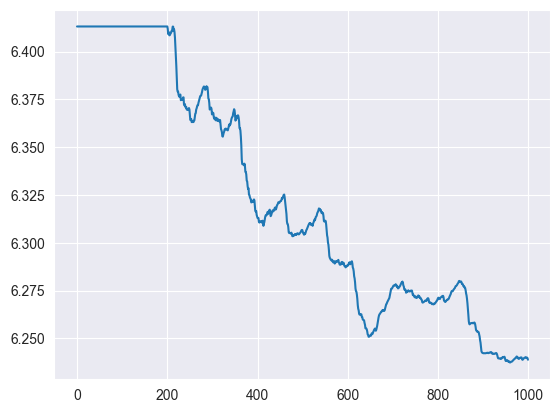

In [55]:
plt.plot(ema(values=accuracies, window=200))

In [56]:
config = {
    'lr': 0.5,
    'sigma': 1.0,
    'n_iterations': 1000,
    'map_side_sizes': [(10, 10, 4), (5, 10, 4), (5, 5, 4)]
}

In [57]:
results = {}

In [58]:
for map_side_size in config['map_side_sizes']:
    som = SOM(map_size=map_side_size, lr=config['lr'], sigma=config['sigma'], n_iterations=config['n_iterations'])
    accuracies = som.train(x_train, x_test)
    results[map_side_size] = accuracies


100%|██████████| 1000/1000 [00:00<00:00, 2104.73it/s]


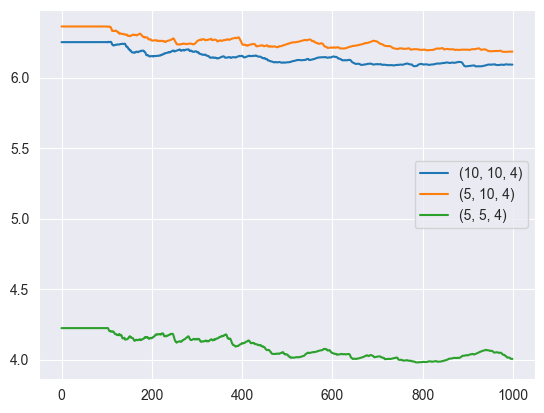

In [59]:
for map_side_size, accuracies in results.items():
    plt.plot(ema(values=accuracies, window=100), label=map_side_size)
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 2258.83it/s]


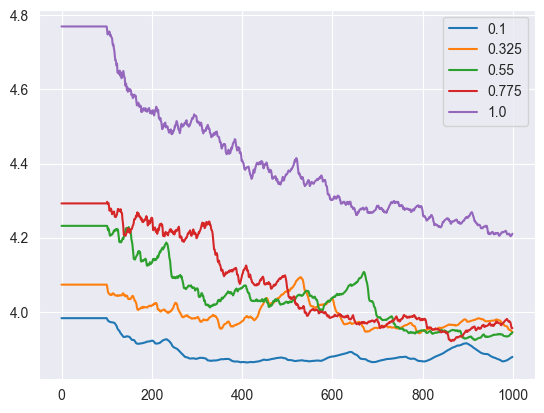

In [65]:
config = {
    'lr': np.linspace(0.1, 1.0, 5),
    'sigma': np.linspace(0.1, 1.0, 5)[::-1],
    'n_iterations': 1000,
    'map_side_sizes': (5, 5, 4)
}

results = {}
for lr in config['lr']:
    som = SOM(map_size=config['map_side_sizes'], lr=lr, sigma=1.0, n_iterations=config['n_iterations'])
    accuracies = som.train(x_train, x_test)
    results[lr] = accuracies
    
for lr, accuracies in results.items():
    plt.plot(ema(values=accuracies, window=100), label=lr)
plt.legend()
plt.show()     

100%|██████████| 1000/1000 [00:00<00:00, 2322.27it/s]


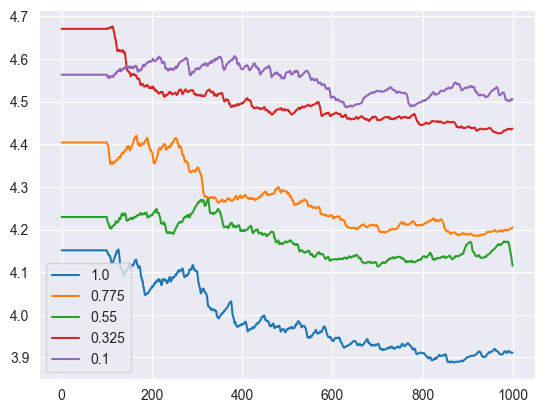

In [67]:
results = {}
for sigma in config['sigma']:
    som = SOM(map_size=config['map_side_sizes'], lr=0.5, sigma=sigma, n_iterations=config['n_iterations'])
    accuracies = som.train(x_train, x_test)
    results[sigma] = accuracies
    
for sigma, accuracies in results.items():
    plt.plot(ema(values=accuracies, window=100), label=sigma)
plt.legend()
plt.show()     

In [40]:
def visualize_weights(weights):
    fig, axes = plt.subplots(nrows=weights.shape[0], ncols=weights.shape[1], figsize=(10, 10))
    for x in range(weights.shape[0]):
        for y in range(weights.shape[1]):
            axes[x, y].imshow(weights[x, y].reshape(-1, 1))
            axes[x, y].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

100%|██████████| 1000/1000 [00:16<00:00, 58.82it/s]


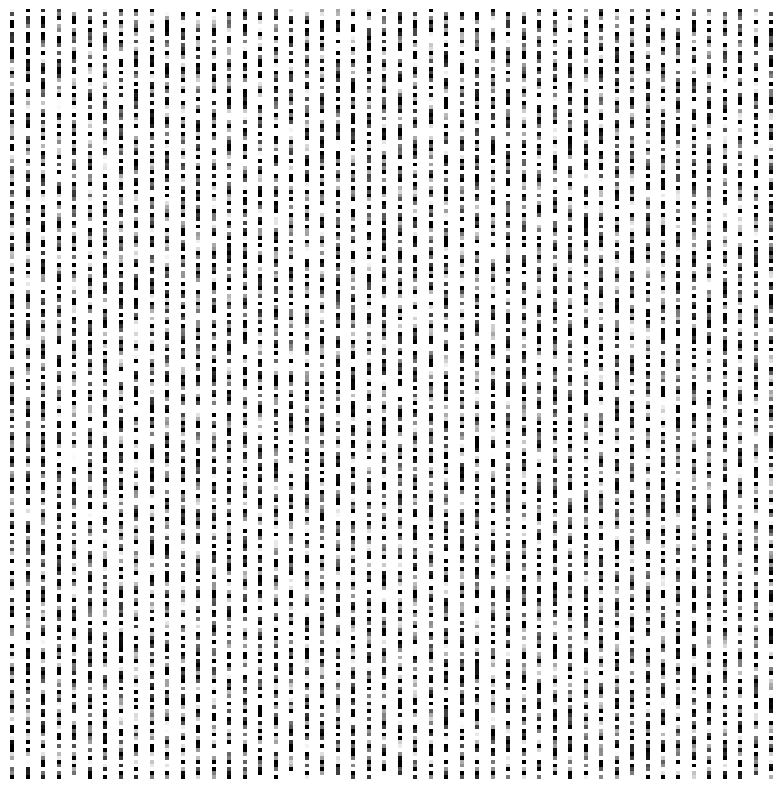

In [44]:
som = SOM(map_size=(50, 50, 4), lr=0.5, sigma=1.0, n_iterations=1000)
som.train(x_train)
visualize_weights(som.get_weights())